## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_response = pd.read_csv('/content/drive/My Drive/Campaign Response Model/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/drive/My Drive/Campaign Response Model/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [4]:
df_response.head()

customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1

In [5]:
df_transactions.head()

customer_id trans_date  tran_amount
0      CS5295 2013-02-11           35
1      CS4768 2015-03-15           39
2      CS2122 2013-02-26           52
3      CS1217 2011-11-16           99
4      CS1850 2013-11-20           78

In [6]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [7]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

customer_id trans_date  tran_amount  recent
0      CS5295 2013-02-11           35   764.0
1      CS4768 2015-03-15           39     2.0
2      CS2122 2013-02-26           52   749.0
3      CS1217 2011-11-16           99  1217.0
4      CS1850 2013-11-20           78   482.0

In [8]:
df_transactions.describe()

tran_amount         recent
count  125000.000000  125000.000000
mean       64.991912     702.499120
std        22.860006     404.169397
min        10.000000       1.000000
25%        47.000000     354.000000
50%        65.000000     702.000000
75%        83.000000    1052.000000
max       105.000000    1401.000000

In [9]:
df_transactions[df_transactions.customer_id == 'CS5295']

customer_id trans_date  tran_amount  recent
0          CS5295 2013-02-11           35   764.0
3556       CS5295 2014-11-25           54   112.0
4218       CS5295 2013-05-22           37   664.0
4710       CS5295 2012-12-24           36   813.0
5986       CS5295 2013-03-22           98   725.0
12777      CS5295 2012-06-03           96  1017.0
13503      CS5295 2012-01-08           77  1164.0
21537      CS5295 2013-10-19           53   514.0
24526      CS5295 2012-02-26           65  1115.0
27655      CS5295 2014-10-02           59   166.0
30094      CS5295 2012-05-02           40  1049.0
34316      CS5295 2014-09-25          100   173.0
39784      CS5295 2013-01-12           88   794.0
43416      CS5295 2013-04-05           48   711.0
44076      CS5295 2012-01-03           60  1169.0
46959      CS5295 2012-08-22           37   937.0
55765      CS5295 2011-10-27          104  1237.0
62054      CS5295 2011-11-07           67  1226.0
62478      CS5295 2014-09-16          104   182.0
65465      CS5295 2014-01-20           37   421.0
66492      CS5295 2014-09-30           42   168.0
67591      CS5295 2013-01-20           43   786.0
67932      CS5295 2011-11-16           65  1217.0
68939      CS5295 2014-09-23          101   175.0
86769      CS5295 2012-05-30           91  1021.0

In [16]:
# Feature lag past 1 year
df_transactions[(df_transactions.recent < 365) & (df_transactions.customer_id == 'CS4768')]

customer_id trans_date  tran_amount  recent
1          CS4768 2015-03-15           39     2.0
48133      CS4768 2014-05-27           52   294.0
59459      CS4768 2014-10-12           60   156.0
61603      CS4768 2014-05-17           75   304.0
63828      CS4768 2014-08-27           48   202.0
87223      CS4768 2014-10-16           78   152.0
88175      CS4768 2014-05-16           40   305.0

In [17]:
# Feature lag past 2 year
df_transactions[(df_transactions.recent < 365*2) & (df_transactions.customer_id == 'CS4768')]

customer_id trans_date  tran_amount  recent
1          CS4768 2015-03-15           39     2.0
24972      CS4768 2014-01-07           49   434.0
36334      CS4768 2013-09-20           76   543.0
37797      CS4768 2013-11-29           80   473.0
48133      CS4768 2014-05-27           52   294.0
49808      CS4768 2013-05-10           56   676.0
53467      CS4768 2013-05-04           43   682.0
59459      CS4768 2014-10-12           60   156.0
61603      CS4768 2014-05-17           75   304.0
63828      CS4768 2014-08-27           48   202.0
75197      CS4768 2013-03-22           43   725.0
77728      CS4768 2013-03-25           35   722.0
81052      CS4768 2013-06-02          105   653.0
85528      CS4768 2013-09-04           68   559.0
87223      CS4768 2014-10-16           78   152.0
88175      CS4768 2014-05-16           40   305.0
91124      CS4768 2013-08-20           37   574.0
92885      CS4768 2013-10-24           89   509.0
93909      CS4768 2013-07-25           86   600.0

In [18]:
# Feature lag past 3 year
df_transactions[(df_transactions.recent < 365*3) & (df_transactions.customer_id == 'CS4768')]

customer_id trans_date  tran_amount  recent
1          CS4768 2015-03-15           39     2.0
6934       CS4768 2012-10-04           96   894.0
15567      CS4768 2012-12-01          105   836.0
24972      CS4768 2014-01-07           49   434.0
26491      CS4768 2012-05-12           92  1039.0
36334      CS4768 2013-09-20           76   543.0
37797      CS4768 2013-11-29           80   473.0
48133      CS4768 2014-05-27           52   294.0
49808      CS4768 2013-05-10           56   676.0
53467      CS4768 2013-05-04           43   682.0
59459      CS4768 2014-10-12           60   156.0
60654      CS4768 2012-03-26           56  1086.0
61603      CS4768 2014-05-17           75   304.0
63828      CS4768 2014-08-27           48   202.0
75197      CS4768 2013-03-22           43   725.0
77728      CS4768 2013-03-25           35   722.0
81052      CS4768 2013-06-02          105   653.0
85528      CS4768 2013-09-04           68   559.0
87223      CS4768 2014-10-16           78   152.0
88175      CS4768 2014-05-16           40   305.0
91124      CS4768 2013-08-20           37   574.0
92885      CS4768 2013-10-24           89   509.0
93909      CS4768 2013-07-25           86   600.0

In [21]:
# Feature lag more than 3 year
df_transactions[(df_transactions.customer_id == 'CS4768')]

customer_id trans_date  tran_amount  recent
1          CS4768 2015-03-15           39     2.0
6934       CS4768 2012-10-04           96   894.0
8467       CS4768 2011-05-20           80  1397.0
15567      CS4768 2012-12-01          105   836.0
24972      CS4768 2014-01-07           49   434.0
26491      CS4768 2012-05-12           92  1039.0
36334      CS4768 2013-09-20           76   543.0
37797      CS4768 2013-11-29           80   473.0
48133      CS4768 2014-05-27           52   294.0
49808      CS4768 2013-05-10           56   676.0
53467      CS4768 2013-05-04           43   682.0
59459      CS4768 2014-10-12           60   156.0
60654      CS4768 2012-03-26           56  1086.0
61603      CS4768 2014-05-17           75   304.0
62381      CS4768 2012-01-01           62  1171.0
63828      CS4768 2014-08-27           48   202.0
75197      CS4768 2013-03-22           43   725.0
77728      CS4768 2013-03-25           35   722.0
81052      CS4768 2013-06-02          105   653.0
83677      CS4768 2011-06-18           71  1368.0
85528      CS4768 2013-09-04           68   559.0
87223      CS4768 2014-10-16           78   152.0
88175      CS4768 2014-05-16           40   305.0
91124      CS4768 2013-08-20           37   574.0
92885      CS4768 2013-10-24           89   509.0
93909      CS4768 2013-07-25           86   600.0

In [27]:
## create data set with RFM variables feature lag 1 year

df_rfm1 = df_transactions[df_transactions.recent < 365].groupby('customer_id').agg({'recent': lambda x:x.min(),                   # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm1.rename(columns={'recent': 'recency_lag1yr', 
                       'customer_id': 'frequency_lag1yr', 
                       'tran_amount': 'monetary_value_lag1yr'}, inplace=True)

In [28]:
df_rfm1 = df_rfm1.reset_index()
df_rfm1.head()

customer_id  recency_lag1yr  frequency_lag1yr  monetary_value_lag1yr
0      CS1112            62.0                 4                    251
1      CS1113            36.0                 6                    393
2      CS1114            33.0                 5                    315
3      CS1115            12.0                 3                    248
4      CS1116           204.0                 4                    286

In [42]:
## create data set with CLV variables feature lag 1 year

df_clv_1 = df_transactions[df_transactions.recent <= 365].groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv_1.rename(columns={'recent': 'recency_lag1yr', 
                       'customer_id': 'frequency_lag1yr', 
                       'tran_amount': 'monetary_value_lag1yr',
                       'trans_date' : 'AOU_lag1yr'}, inplace=True)

df_clv_1['ticket_size_lag1yr'] = df_clv_1['monetary_value_lag1yr'] / df_clv_1['frequency_lag1yr']
df_clv_1 = df_clv_1.reset_index()
df_clv_1.head()

customer_id  recency_lag1yr  ...  AOU_lag1yr  ticket_size_lag1yr
0      CS1112            62.0  ...         260           62.750000
1      CS1113            36.0  ...         296           65.500000
2      CS1114            33.0  ...         165           63.000000
3      CS1115            12.0  ...         330           82.666667
4      CS1116           204.0  ...         157           71.500000

[5 rows x 6 columns]

In [43]:
## create data set with CLV variables feature lag 2 year

df_clv_2 = df_transactions[df_transactions.recent <= 365*2].groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv_2.rename(columns={'recent': 'recency_lag2yr', 
                       'customer_id': 'frequency_lag2yr', 
                       'tran_amount': 'monetary_value_lag2yr',
                       'trans_date' : 'AOU_lag2yr'}, inplace=True)

df_clv_2['ticket_size_lag2yr'] = df_clv_2['monetary_value_lag2yr'] / df_clv_2['frequency_lag2yr']
df_clv_2 = df_clv_2.reset_index()
df_clv_2.head()

customer_id  recency_lag2yr  ...  AOU_lag2yr  ticket_size_lag2yr
0      CS1112            62.0  ...         562           59.666667
1      CS1113            36.0  ...         660           70.454545
2      CS1114            33.0  ...         626           73.090909
3      CS1115            12.0  ...         715           75.545455
4      CS1116           204.0  ...         199           66.600000

[5 rows x 6 columns]

In [44]:
## create data set with CLV variables feature lag 3 year

df_clv_3 = df_transactions[df_transactions.recent <= 365*3].groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv_3.rename(columns={'recent': 'recency_lag3yr', 
                       'customer_id': 'frequency_lag3yr', 
                       'tran_amount': 'monetary_value_lag3yr',
                       'trans_date' : 'AOU_lag3yr'}, inplace=True)

df_clv_3['ticket_size_lag3yr'] = df_clv_3['monetary_value_lag3yr'] / df_clv_3['frequency_lag3yr']
df_clv_3 = df_clv_3.reset_index()
df_clv_3.head()

customer_id  recency_lag3yr  ...  AOU_lag3yr  ticket_size_lag3yr
0      CS1112            62.0  ...        1011           66.666667
1      CS1113            36.0  ...        1046           73.294118
2      CS1114            33.0  ...        1005           71.857143
3      CS1115            12.0  ...        1046           76.000000
4      CS1116           204.0  ...         872           64.625000

[5 rows x 6 columns]

In [45]:
## create data set with CLV variables feature lag more than 3 year

df_clv_4 = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv_4.rename(columns={'recent': 'recency_lagmore3yr', 
                       'customer_id': 'frequency_lagmore3yr', 
                       'tran_amount': 'monetary_value_lagmore3yr',
                       'trans_date' : 'AOU_lagmore3yr'}, inplace=True)

df_clv_4['ticket_size_lagmore3yr'] = df_clv_4['monetary_value_lagmore3yr'] / df_clv_4['frequency_lagmore3yr']
df_clv_4 = df_clv_4.reset_index()
df_clv_4.head()

customer_id  recency_lagmore3yr  ...  AOU_lagmore3yr  ticket_size_lagmore3yr
0      CS1112                62.0  ...            1309               67.466667
1      CS1113                36.0  ...            1354               74.500000
2      CS1114                33.0  ...            1309               75.368421
3      CS1115                12.0  ...            1303               75.409091
4      CS1116               204.0  ...            1155               65.923077

[5 rows x 6 columns]

In [63]:
from functools import reduce
data_frames = [df_clv_1,df_clv_2, df_clv_3, df_clv_4]
df_clv = reduce(lambda  left,right: pd.merge(left,right,on=['customer_id'],
                                            how='outer'), data_frames).fillna('0')

In [64]:
# drop recency column
df_clv = df_clv.drop(['recency_lag1yr', 'recency_lag2yr', 'recency_lag3yr'], axis=1)

In [65]:
df_clv

customer_id frequency_lag1yr  ... AOU_lagmore3yr ticket_size_lagmore3yr
0         CS1112                4  ...           1309              67.466667
1         CS1113                6  ...           1354              74.500000
2         CS1114                5  ...           1309              75.368421
3         CS1115                3  ...           1303              75.409091
4         CS1116                4  ...           1155              65.923077
...          ...              ...  ...            ...                    ...
6884      CS7297                0  ...            649              50.200000
6885      CS7413                0  ...            585              58.166667
6886      CS7638                0  ...            284              55.000000
6887      CS8376                0  ...            152              59.750000
6888      CS8753                0  ...            578              45.181818

[6889 rows x 18 columns]

## **Calculating response rate**

In [53]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

response  customer_id
0         0         6237
1         1          647

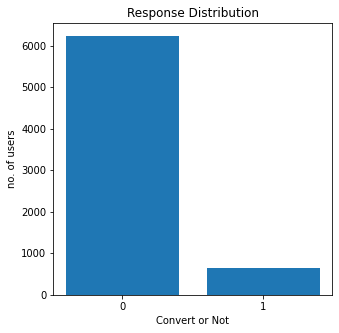

In [54]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [67]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

customer_id  response  ... AOU_lagmore3yr ticket_size_lagmore3yr
0      CS1112         0  ...           1309              67.466667
1      CS1113         0  ...           1354              74.500000
2      CS1114         1  ...           1309              75.368421
3      CS1115         1  ...           1303              75.409091
4      CS1116         1  ...           1155              65.923077

[5 rows x 19 columns]

## **Creating train and test dataset**

In [68]:
## spliting dataframe into X and y
X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [69]:
## creating train and test dataset
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

In [79]:
print("Number transactions X_train dataset: ", X_train_clv.shape)
print("Number transactions y_train dataset: ", y_train_clv.shape)
print("Number transactions X_test dataset: ", X_test_clv.shape)
print("Number transactions y_test dataset: ", y_test_clv.shape)

Number transactions X_train dataset:  (4818, 17)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 17)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

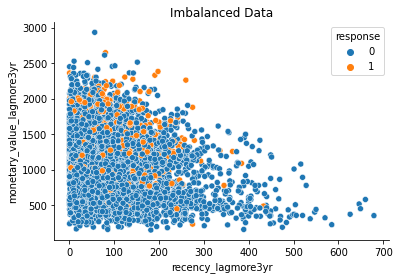

In [83]:
sns.scatterplot(data=df_modeling_clv, x='recency_lagmore3yr', y='monetary_value_lagmore3yr', hue='response')
sns.despine()
plt.title("Imbalanced Data")

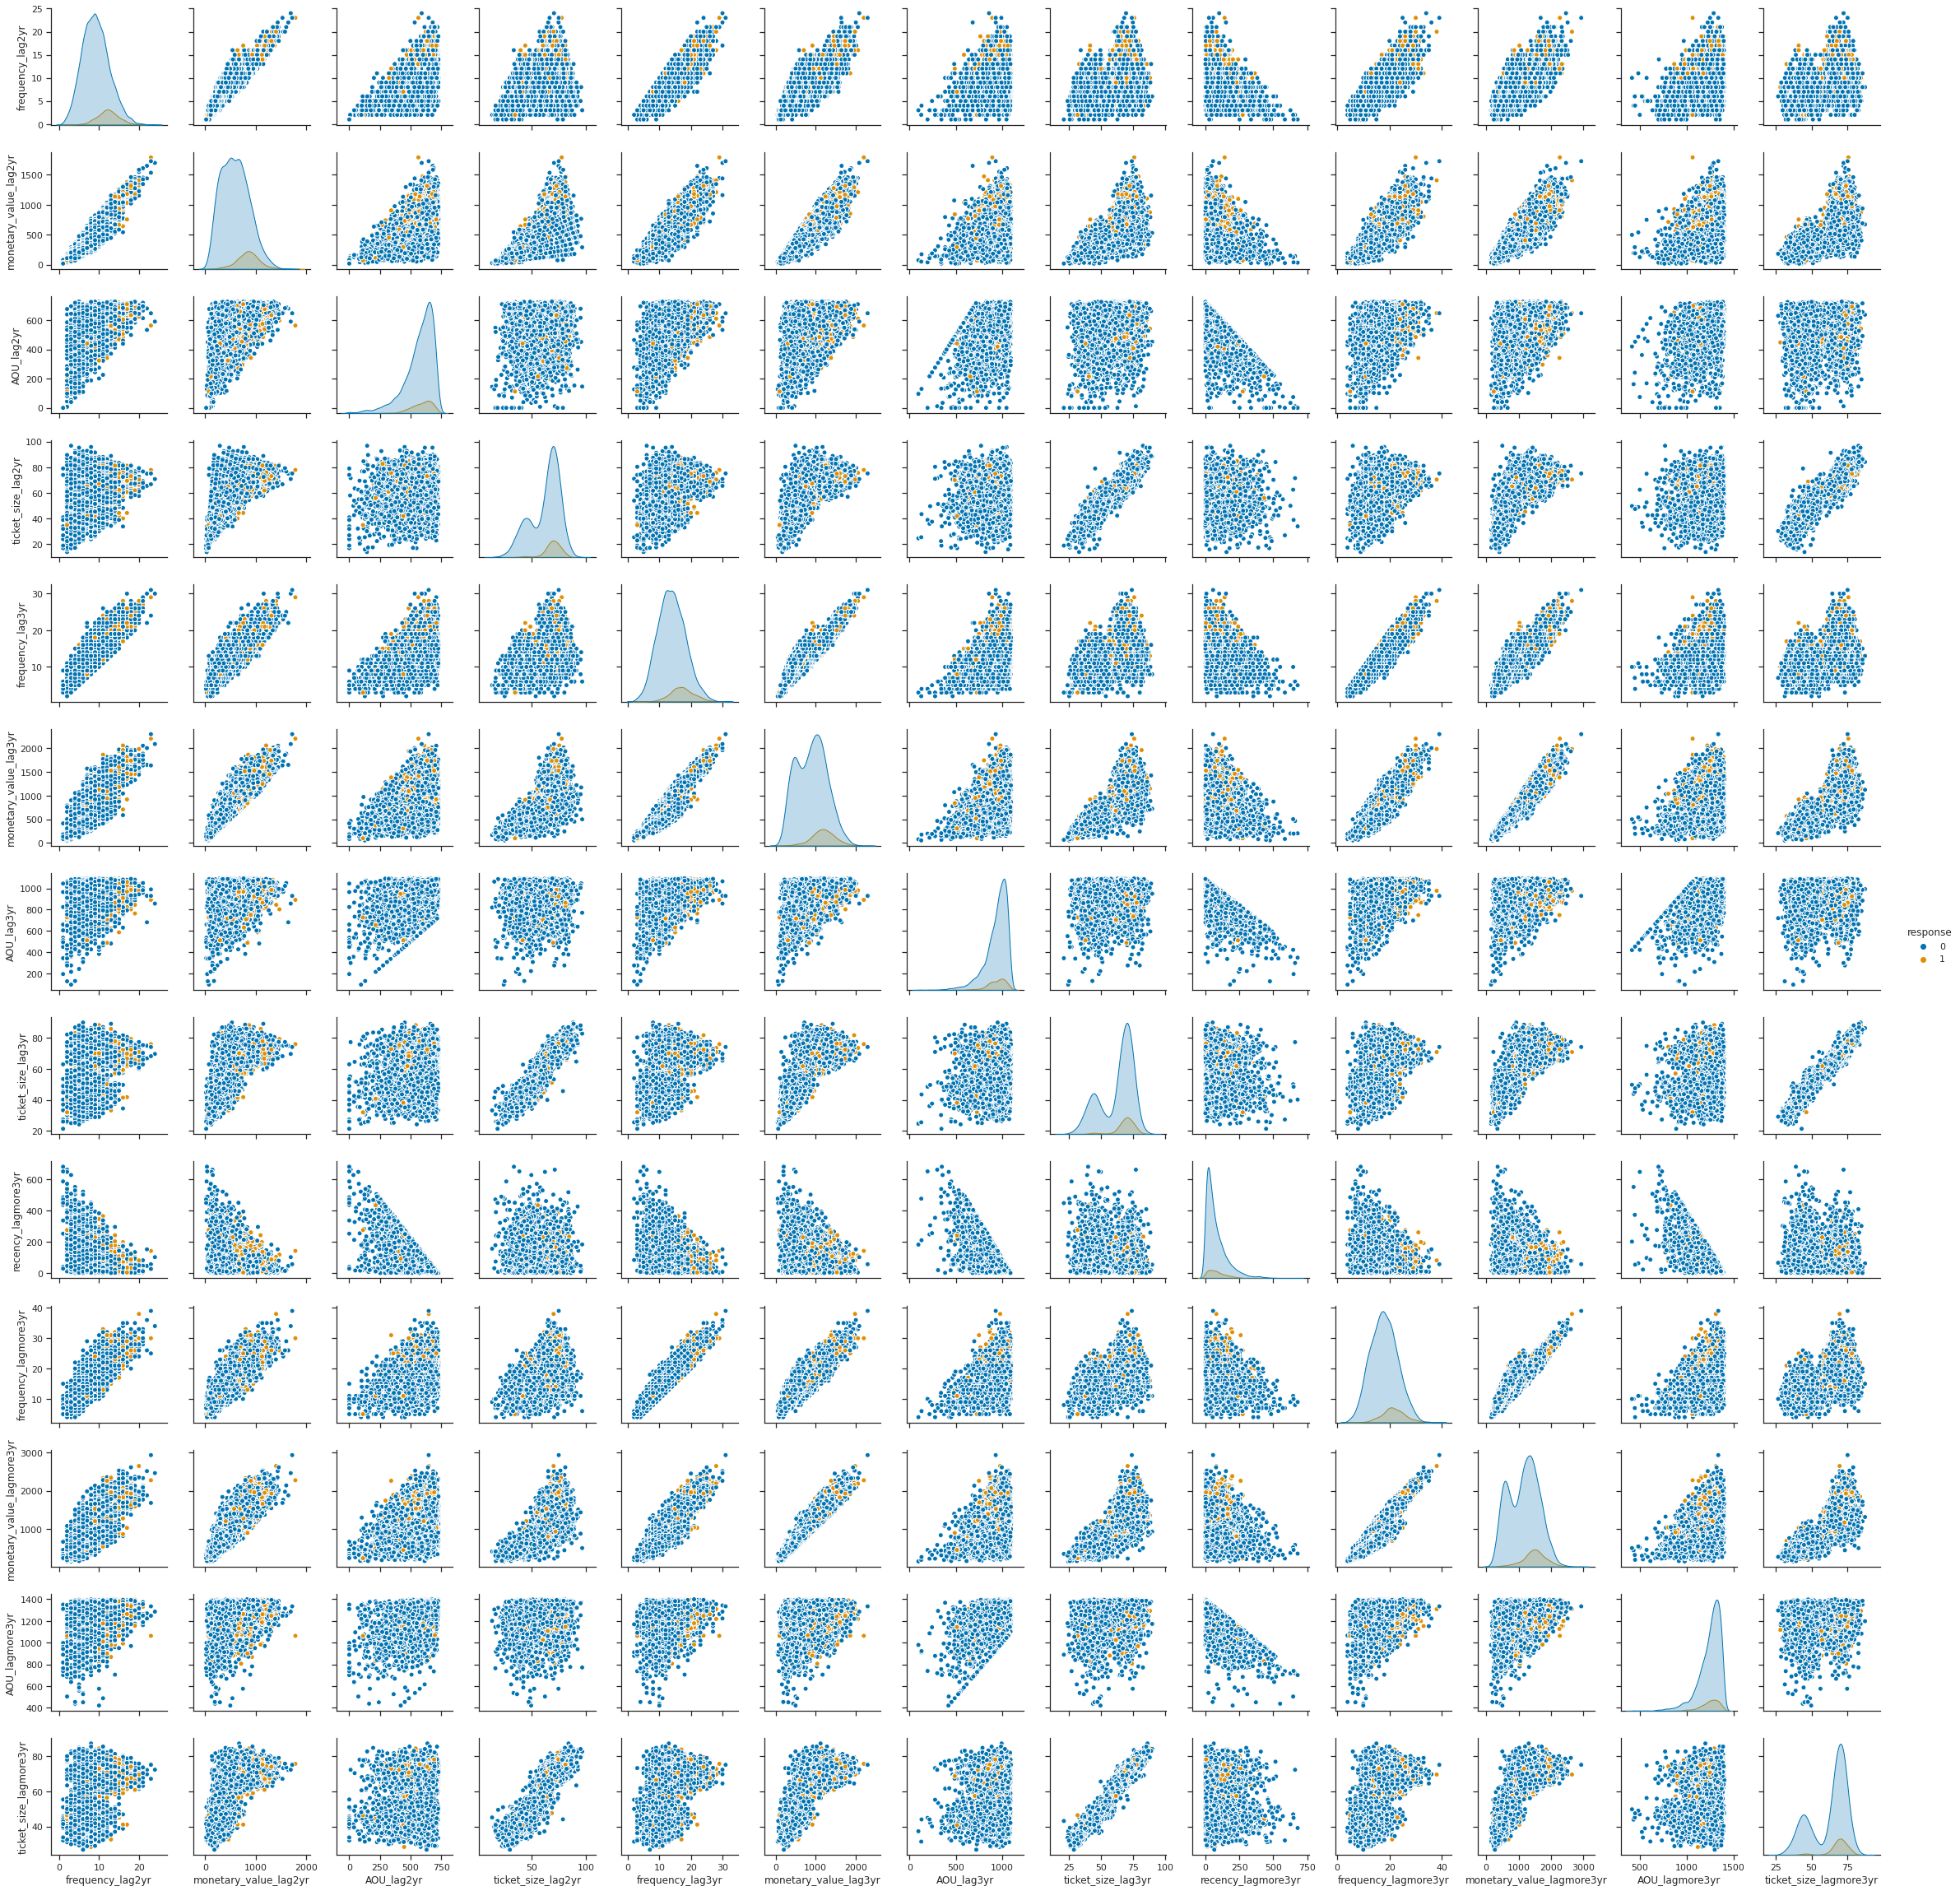

In [102]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(
    df_modeling_clv, 
    hue="response", 
    diag_kind='kde', 
    diag_kws=dict(shade=True),
    palette='colorblind',
    plot_kws=dict(linewidth=1)
)

plt.show()

## **Fixing imbalanced with SMOTE**

In [88]:
sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [89]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      4389
           1       0.72      0.76      0.74      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1848
           1       0.23      0.74      0.35       218

    accuracy                           0.71      2066
   macro avg       0.59      0.72      0.58      2066
weighted avg       0.88      0.71      0.76      2066



## **XGBoost**

In [90]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.746592
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.765257
[2]	validation_0-auc:0.766024
[3]	validation_0-auc:0.773388
[4]	validation_0-auc:0.772953
[5]	validation_0-auc:0.773852
[6]	validation_0-auc:0.773137
[7]	validation_0-auc:0.776174
[8]	validation_0-auc:0.775963
[9]	validation_0-auc:0.775662
[10]	validation_0-auc:0.776621
[11]	validation_0-auc:0.776631
[12]	validation_0-auc:0.778542
[13]	validation_0-auc:0.777897
[14]	validation_0-auc:0.779354
[15]	validation_0-auc:0.779957
[16]	validation_0-auc:0.780989
[17]	validation_0-auc:0.782434
[18]	validation_0-auc:0.782643
[19]	validation_0-auc:0.782064
[20]	validation_0-auc:0.781977
[21]	validation_0-auc:0.781694
[22]	validation_0-auc:0.781553
[23]	validation_0-auc:0.781905
Stopping. Best iteration:
[18]	validation_0-auc:0.782643

training set
              precision    recall  f1-score   support

           0       0.82      0.64      0.72      43

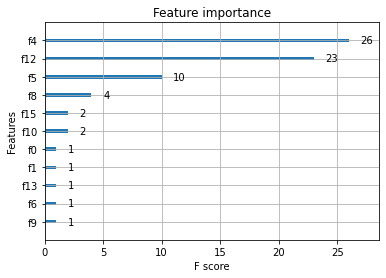

In [91]:
xgb.plot_importance(xgb_model)

In [103]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.751844
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.750185
[2]	validation_0-auc:0.751481
[3]	validation_0-auc:0.747989
[4]	validation_0-auc:0.768421
[5]	validation_0-auc:0.773262
[6]	validation_0-auc:0.780026
[7]	validation_0-auc:0.784564
[8]	validation_0-auc:0.784384
[9]	validation_0-auc:0.785765
[10]	validation_0-auc:0.784857
[11]	validation_0-auc:0.782887
[12]	validation_0-auc:0.784293
[13]	validation_0-auc:0.784303
[14]	validation_0-auc:0.787468
[15]	validation_0-auc:0.785877
[16]	validation_0-auc:0.786856
[17]	validation_0-auc:0.788005
[18]	validation_0-auc:0.788642
[19]	validation_0-auc:0.787925
[20]	validation_0-auc:0.787602
[21]	validation_0-auc:0.787849
[22]	validation_0-auc:0.788367
[23]	validation_0-auc:0.788995
[24]	validation_0-auc:0.788616
[25]	validation_0-auc:0.788266
[26]	validation_0-auc:0.787329
[27]	validation_0-auc:0.786463
[28]	validation_0-auc:0.78631
Stopping

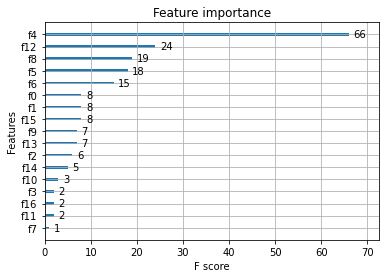

In [97]:
xgb.plot_importance(xgb_model)

In [100]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
thresholds = sort(xgb_model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_SMOTE_clv)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_SMOTE_clv)
	# eval model
	select_X_test = selection.transform(X_test_clv)
	predictions = selection_model.predict(select_X_test)
	accuracy = accuracy_score(y_test_clv, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.005, n=17, Accuracy: 82.48%
Thresh=0.012, n=16, Accuracy: 82.58%
Thresh=0.016, n=15, Accuracy: 82.48%
Thresh=0.020, n=14, Accuracy: 82.48%
Thresh=0.021, n=13, Accuracy: 81.90%
Thresh=0.021, n=12, Accuracy: 82.43%
Thresh=0.025, n=11, Accuracy: 81.66%
Thresh=0.028, n=10, Accuracy: 82.91%
Thresh=0.035, n=9, Accuracy: 80.59%
Thresh=0.044, n=8, Accuracy: 80.11%
Thresh=0.063, n=7, Accuracy: 80.59%
Thresh=0.080, n=6, Accuracy: 79.67%
Thresh=0.081, n=5, Accuracy: 79.04%
Thresh=0.083, n=4, Accuracy: 80.06%
Thresh=0.107, n=3, Accuracy: 79.91%
Thresh=0.137, n=2, Accuracy: 62.92%
Thresh=0.222, n=1, Accuracy: 47.58%


In [74]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [75]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }

]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.9min finished


In [76]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7527347401025883
[[1190  658]
 [  59  159]]
test set
              precision    recall  f1-score   support

           0       0.95      0.64      0.77      1848
           1       0.19      0.73      0.31       218

    accuracy                           0.65      2066
   macro avg       0.57      0.69      0.54      2066
weighted avg       0.87      0.65      0.72      2066



In [77]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7fcc98ae5050>}
